# Implementation of Hegselmann & Krause with a Truth Signal

The main reference is: Douven, I. (2010). Simulating peer disagreements. Studies in History and Philosophy of Science Part A, 41(2), 148–157.

It was designed for the course "Agent-Based Simulations in Philosophy" (Winter Term 2023, by Dunja Seselja and Christian Straßer) as a demonstration of how to code an ABM in julia utilizing the Agent.jl library. The code is itself a slight variant of the code for a Hegselmann & Krause model in the tutorial of Agent.jl (https://juliadynamics.github.io/AgentsExampleZoo.jl/dev/examples/hk/)

The model also implements a new mode of reasoning for agents, namely the ability to memorize experimental results (signals from the truth signal) and to average on them.

The model shows that Douven's insights strongly rely on the fact that agents don't have memory.

Student can feel encouraged to play around with the model.

In [1]:
import Pkg;
Pkg.add("Agents")
Pkg.add("DataFrames")
Pkg.add("CairoMakie")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
using Agents
using Statistics: mean

In [3]:
mutable struct HKAgent <: AbstractAgent
    id::Int
    old_opinion::Float64
    new_opinion::Float64
    previous_opinion::Float64
    previous_data::Array{Float64,1}   
    memory::Int
end

In [4]:
function randtau(τ, ξ)
    τ + (rand(Float64) * 2 * ξ - ξ)
end

function hk_model(; numagents = 25, ϵ = 0.1, τ = .75, ξ = .2, α = .5, memory = 2)
    model = ABM(HKAgent, scheduler = Schedulers.fastest, 
       properties = Dict(:ϵ => ϵ, :τ => τ, :ξ => ξ, :α => α, :memory => memory))
    for i in 1:numagents
        o = rand(model.rng)
        m::Array{Float64, 1} = [randtau(τ,ξ) for i in 1:memory] 
        add_agent!(model, o, o, -1, m, model.memory)
    end
    return model
end

hk_model (generic function with 1 method)

In [5]:
function boundfilter(agent, model)
    filter(
        j -> abs(agent.old_opinion - j) < model.ϵ,
        [a.old_opinion for a in allagents(model)],
    )
end

boundfilter (generic function with 1 method)

In [6]:
function agent_step!(agent, model)
    agent.previous_opinion = agent.old_opinion
    deleteat!(agent.previous_data,1)
    push!(agent.previous_data, randtau(model.τ,model.ξ))
    reasData = mean(agent.previous_data)
    agent.new_opinion = model.α * mean(boundfilter(agent,model)) + (1-model.α) * reasData
end

agent_step! (generic function with 1 method)

In [7]:
function model_step!(model)
    for a in allagents(model)
        a.old_opinion = a.new_opinion
    end
end

model_step! (generic function with 1 method)

In [8]:
function model_run(; kwargs...)
    model = hk_model(; kwargs...)
    agent_data, _ = run!(model, agent_step!, model_step!, 60; adata = [:new_opinion])
    return agent_data
end

model_run (generic function with 1 method)

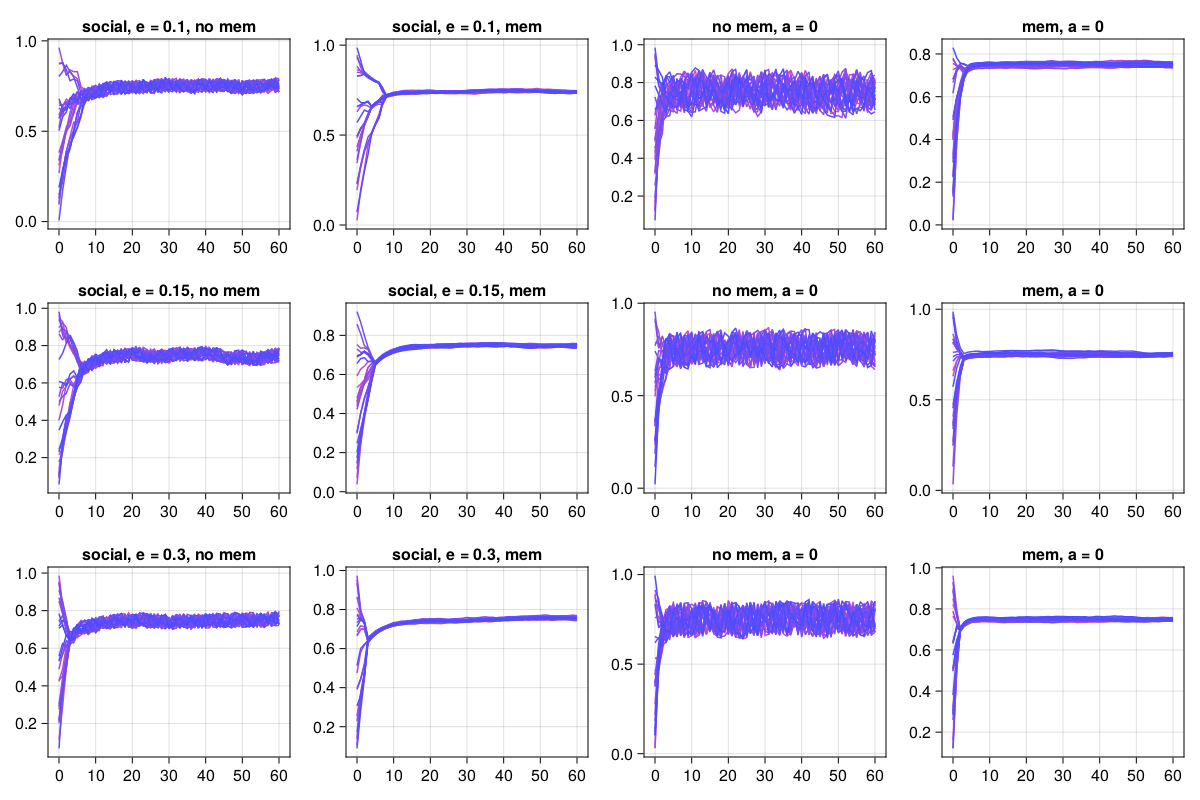

In [9]:
using DataFrames, CairoMakie

const cmap = cgrad(:lightrainbow)
plotsim(ax, data) =
    for grp in groupby(data, :id)
        lines!(ax, grp.step, grp.new_opinion, color = cmap[grp.id[1]/100])
    end

eps = [0.1, 0.15, 0.3]
figure = Figure(resolution = (1200, 800))
for (i, e) in enumerate(eps)
    ax = figure[i, 1] = Axis(figure; title = "social, e = $e, no mem")
    e_data = model_run(α=.8,ϵ = e, memory = 1)
    plotsim(ax, e_data)
end
for (i,e) in enumerate(eps)
    ax = figure[i,2] = Axis(figure; title = "social, e = $e, mem")
    e_data = model_run(α=.8,ϵ = e, memory = 20)
    plotsim(ax, e_data)
end
for (i,e) in enumerate(eps)
    ax = figure[i,3] = Axis(figure; title = "no mem, a = 0")
    e_data = model_run(α = .5
, ϵ = e, memory = 1)
    plotsim(ax, e_data)
end
for (i,e) in enumerate(eps)
    ax = figure[i,4] = Axis(figure; title = "mem, a = 0")
    e_data = model_run(α = .5, ϵ = e, memory = 60)
    plotsim(ax, e_data)
end
figure